# Calorie Burn Predictions - Ensemble Model

## Packages

In [ ]:
# Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline Functions
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Tuning Functions
from sklearn.model_selection import GridSearchCV

# Modelling Functions
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

import time

## Functions

In [2]:
# Root Mean Squared Logarithmic Error
def RMSLE(actual, prediction):
    """
    A function that takes two input arrays and returns the Root Mean Squared Logarithmic Error (RMSLE).
    
    Parameters
    ----------
    actual : array-like
        The true values.

    prediction : array-like
        The predictions.
    
    Returns
    -------
    float
        The RMSLE.
    """

    # Ensure inputs are numpy arrays
    try:
        actual = np.asarray(actual)
        prediction = np.asarray(prediction)
    except:
        raise TypeError('Could not convert the inputs to arrays.')

    # Check whether the arrays are of equal lengths
    if len(actual) != len(prediction):
        raise ValueError('The two input arrays must be of equal length.')
    
    # Ensure all the numbers in the arrays are non-negative
    if (actual<0).any() or (prediction<0).any():
        raise ValueError('The true values and predictions must both be non-negative.')

    # Return the RMSLE
    return float( np.sqrt( np.mean( (np.log(1+prediction) - np.log(1+actual)) ** 2 ) ) )

# Non-Negativity Criteria
def non_negative(array):
    """
    A function to ensure that all predictions are non-negative. 

    Parameters
    ----------
    array : array-like
        An array containing prediction values.
    
    Returns
    -------
    array-like
        An array containing non-negative predictions.
    """
    return np.clip(array, 0.0, None)

def custom_scoring_func(estimator, X, y):
    """
    A function to use in RandomSearchCV and GridSearchCV to find the best parameter combinations to minimize the RMSLE score.

    Parameters
    ----------
    estimator: model object
        The model object itself.
    X: array-like
        An array containing the input features.
    y: array-like
        An array containing the actual values.

    Returns
    -------
    float
        The negative RMSLE score when it is maximized in RandomizedSearchCV or GridSearchCV.
    """
    prediction = estimator.predict(X)
    prediction = non_negative(prediction)
    return -RMSLE(y, prediction)

The custom_scoring_func() function will be used when hyperparameter tuning to optimize for the RMSLE score.

## Reading

In [40]:
train = pd.read_csv('Data/train.csv', index_col='id')
print(f'The training set has {train.shape[0]:,} rows and {train.shape[1]} columns.')
train.head()

The training set has 750,000 rows and 8 columns.


,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [41]:
test = pd.read_csv('Data/test.csv', index_col='id')
print(f'The test set has {test.shape[0]:,} rows and {test.shape[1]} columns.')
test.head()

The test set has 250,000 rows and 7 columns.


,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
id,,,,,,,
750000,male,45,177.0,81.0,7.0,87.0,39.8
750001,male,26,200.0,97.0,20.0,101.0,40.5
750002,female,29,188.0,85.0,16.0,102.0,40.4
750003,female,39,172.0,73.0,20.0,107.0,40.6
750004,female,30,173.0,67.0,16.0,94.0,40.5


## Feature Engineering
Features created in the exploration notebook are recreated here, along with a calorie burn per minute feature to detect any outliers (not used in modelling).

In [6]:
# Male indicator variable
train['Male'] = (train['Sex'] == 'male').astype(int)

# Senior indicator variable
train['Senior'] = (train['Age'] >= 60).astype(int)

# Body Mass Index (BMI)
train['BMI'] = train['Weight'] / (train['Height']/100)**2

# Maximum Heart Rate
train['max_HR'] = 208 - 0.7 * train['Age']

# Relative Intensity: Heart Rate / Estimated Maximum Heart Rate
train['Relative_Intensity'] = train['Heart_Rate'] / train['max_HR']

# Calories per Minute --> Done to identify potential outliers
train['Calories_per_min'] = train['Calories'] / train['Duration']

# Reorder the columns into a sensible order and to have the target on the end
train = train[['Sex', 'Male', 'Age', 'Senior', 'Weight', 'Height', 'BMI', 'max_HR', 'Heart_Rate', 'Relative_Intensity', 'Body_Temp', 'Duration', 'Calories', 'Calories_per_min']]
train.head()

,Sex,Male,Age,Senior,Weight,Height,BMI,max_HR,Heart_Rate,Relative_Intensity,Body_Temp,Duration,Calories,Calories_per_min
id,,,,,,,,,,,,,,
0,male,1,36,0,82.0,189.0,22.955684,182.8,101.0,0.552516,41.0,26.0,150.0,5.769231
1,female,0,64,1,60.0,163.0,22.582709,163.2,85.0,0.520833,39.7,8.0,34.0,4.250000
2,female,0,51,0,64.0,161.0,24.690405,172.3,84.0,0.487522,39.8,7.0,29.0,4.142857
3,male,1,20,0,90.0,192.0,24.414062,194.0,105.0,0.541237,40.7,25.0,140.0,5.600000
4,female,0,38,0,61.0,166.0,22.136740,181.4,102.0,0.562293,40.6,25.0,146.0,5.840000


In [7]:
# Male indicator variable
test['Male'] = (test['Sex'] == 'male').astype(int)

# Senior indicator variable
test['Senior'] = (test['Age'] >= 60).astype(int)

# Body Mass Index (BMI)
test['BMI'] = test['Weight'] / (test['Height']/100)**2

# Maximum Heart Rate
test['max_HR'] = 208 - 0.7 * test['Age']

# Relative Intensity: Heart Rate / Estimated Maximum Heart Rate
test['Relative_Intensity'] = test['Heart_Rate'] / test['max_HR']

# Reorder the columns into a sensible order
test = test[['Sex', 'Male', 'Age', 'Senior', 'Weight', 'Height', 'BMI', 'max_HR', 'Heart_Rate', 'Relative_Intensity', 'Body_Temp', 'Duration']]
test.head()

,Sex,Male,Age,Senior,Weight,Height,BMI,max_HR,Heart_Rate,Relative_Intensity,Body_Temp,Duration
id,,,,,,,,,,,,
750000,male,1,45,0,81.0,177.0,25.854639,176.5,87.0,0.492918,39.8,7.0
750001,male,1,26,0,97.0,200.0,24.250000,189.8,101.0,0.532139,40.5,20.0
750002,female,0,29,0,85.0,188.0,24.049344,187.7,102.0,0.543420,40.4,16.0
750003,female,0,39,0,73.0,172.0,24.675500,180.7,107.0,0.592142,40.6,20.0
750004,female,0,30,0,67.0,173.0,22.386314,187.0,94.0,0.502674,40.5,16.0


### Interactions
Include the interactions found to be important in the exploration notebook, as well as additional interactions to improve the performance of the MLP model.

In [8]:
## Two-Way Interactions
# Time Interactions
train['Duration*Weight'] = train['Duration']*train['Weight']
train['Duration*Relative_Intensity'] = train['Duration']*train['Relative_Intensity']
train['Duration*Heart_Rate'] = train['Duration']*train['Heart_Rate']
train['Duration*Body_Temp'] = train['Duration']*train['Body_Temp']

# Intensity Interactions
train['Relative_Intensity*Body_Temp'] = train['Relative_Intensity']*train['Body_Temp']

## Three-Way Interactions
train['Weight*Duration*Relative_Intensity'] = train['Weight']*train['Duration']*train['Relative_Intensity']

## Four-Way Interactions
train['Age*Weight*Duration*Relative_Intensity'] = train['Age']*train['Weight']*train['Duration']*train['Relative_Intensity']

train.head()

,Sex,Male,Age,Senior,Weight,Height,BMI,max_HR,Heart_Rate,Relative_Intensity,...,Duration,Calories,Calories_per_min,Duration*Weight,Duration*Relative_Intensity,Duration*Heart_Rate,Duration*Body_Temp,Relative_Intensity*Body_Temp,Weight*Duration*Relative_Intensity,Age*Weight*Duration*Relative_Intensity
id,,,,,,,,,,,,,,,,,,,,,
0,male,1,36,0,82.0,189.0,22.955684,182.8,101.0,0.552516,...,26.0,150.0,5.769231,2132.0,14.365427,2626.0,1066.0,22.653173,1177.964989,42406.739606
1,female,0,64,1,60.0,163.0,22.582709,163.2,85.0,0.520833,...,8.0,34.0,4.250000,480.0,4.166667,680.0,317.6,20.677083,250.000000,16000.000000
2,female,0,51,0,64.0,161.0,24.690405,172.3,84.0,0.487522,...,7.0,29.0,4.142857,448.0,3.412652,588.0,278.6,19.403366,218.409750,11138.897272
3,male,1,20,0,90.0,192.0,24.414062,194.0,105.0,0.541237,...,25.0,140.0,5.600000,2250.0,13.530928,2625.0,1017.5,22.028351,1217.783505,24355.670103
4,female,0,38,0,61.0,166.0,22.136740,181.4,102.0,0.562293,...,25.0,146.0,5.840000,1525.0,14.057332,2550.0,1015.0,22.829107,857.497244,32584.895259


In [9]:
## Two-Way Interactions
# Time Interactions
test['Duration*Weight'] = test['Duration']*test['Weight']
test['Duration*Relative_Intensity'] = test['Duration']*test['Relative_Intensity']
test['Duration*Heart_Rate'] = test['Duration']*test['Heart_Rate']
test['Duration*Body_Temp'] = test['Duration']*test['Body_Temp']

# Intensity Interactions
test['Relative_Intensity*Body_Temp'] = test['Relative_Intensity']*test['Body_Temp']

## Three-Way Interactions
test['Weight*Duration*Relative_Intensity'] = test['Weight']*test['Duration']*test['Relative_Intensity']

## Four-Way Interactions
test['Age*Weight*Duration*Relative_Intensity'] = test['Age']*test['Weight']*test['Duration']*test['Relative_Intensity']

test.head()

,Sex,Male,Age,Senior,Weight,Height,BMI,max_HR,Heart_Rate,Relative_Intensity,Body_Temp,Duration,Duration*Weight,Duration*Relative_Intensity,Duration*Heart_Rate,Duration*Body_Temp,Relative_Intensity*Body_Temp,Weight*Duration*Relative_Intensity,Age*Weight*Duration*Relative_Intensity
id,,,,,,,,,,,,,,,,,,,
750000,male,1,45,0,81.0,177.0,25.854639,176.5,87.0,0.492918,39.8,7.0,567.0,3.450425,609.0,278.6,19.618130,279.484419,12576.798867
750001,male,1,26,0,97.0,200.0,24.250000,189.8,101.0,0.532139,40.5,20.0,1940.0,10.642782,2020.0,810.0,21.551633,1032.349842,26841.095890
750002,female,0,29,0,85.0,188.0,24.049344,187.7,102.0,0.543420,40.4,16.0,1360.0,8.694726,1632.0,646.4,21.954182,739.051678,21432.498668
750003,female,0,39,0,73.0,172.0,24.675500,180.7,107.0,0.592142,40.6,20.0,1460.0,11.842833,2140.0,812.0,24.040952,864.526840,33716.546763
750004,female,0,30,0,67.0,173.0,22.386314,187.0,94.0,0.502674,40.5,16.0,1072.0,8.042781,1504.0,648.0,20.358289,538.866310,16165.989305


In [10]:
interactions = ['Duration*Weight', 'Duration*Relative_Intensity', 'Duration*Heart_Rate', 'Duration*Body_Temp', 
                'Relative_Intensity*Body_Temp', 'Weight*Duration*Relative_Intensity', 'Age*Weight*Duration*Relative_Intensity']

## Outlier Removal

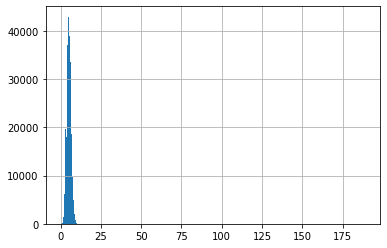

count    750000.000000
mean          5.145520
std           1.438803
min           0.115385
25%           4.200000
50%           5.125000
75%           6.050000
max         189.000000
Name: Calories_per_min, dtype: float64

In [11]:
# Show the distribution of calories per minute
train['Calories_per_min'].hist(bins=1000)
plt.show()
train['Calories_per_min'].describe()

In [12]:
# Remove outliers based on exercise physiology limitations
lower_bound = 1.0 # Resting calorie burn is around 1.0 calories per minute
upper_bound = 15.0 # Most people can burn up to 15 calories per minute; sometimes even more in exceptional cases

# Filter to keep only acceptable values
train = train[ (train['Calories_per_min'] >= lower_bound) & (train['Calories_per_min'] <= upper_bound)]
train.head()

,Sex,Male,Age,Senior,Weight,Height,BMI,max_HR,Heart_Rate,Relative_Intensity,...,Duration,Calories,Calories_per_min,Duration*Weight,Duration*Relative_Intensity,Duration*Heart_Rate,Duration*Body_Temp,Relative_Intensity*Body_Temp,Weight*Duration*Relative_Intensity,Age*Weight*Duration*Relative_Intensity
id,,,,,,,,,,,,,,,,,,,,,
0,male,1,36,0,82.0,189.0,22.955684,182.8,101.0,0.552516,...,26.0,150.0,5.769231,2132.0,14.365427,2626.0,1066.0,22.653173,1177.964989,42406.739606
1,female,0,64,1,60.0,163.0,22.582709,163.2,85.0,0.520833,...,8.0,34.0,4.250000,480.0,4.166667,680.0,317.6,20.677083,250.000000,16000.000000
2,female,0,51,0,64.0,161.0,24.690405,172.3,84.0,0.487522,...,7.0,29.0,4.142857,448.0,3.412652,588.0,278.6,19.403366,218.409750,11138.897272
3,male,1,20,0,90.0,192.0,24.414062,194.0,105.0,0.541237,...,25.0,140.0,5.600000,2250.0,13.530928,2625.0,1017.5,22.028351,1217.783505,24355.670103
4,female,0,38,0,61.0,166.0,22.136740,181.4,102.0,0.562293,...,25.0,146.0,5.840000,1525.0,14.057332,2550.0,1015.0,22.829107,857.497244,32584.895259


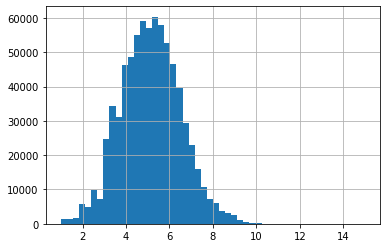

count    749773.000000
mean          5.143369
std           1.369626
min           1.000000
25%           4.200000
50%           5.125000
75%           6.050000
max          15.000000
Name: Calories_per_min, dtype: float64

In [13]:
# Show the new distribution of calories per minute without any outliers
train['Calories_per_min'].hist(bins=50)
plt.show()
train['Calories_per_min'].describe()

## Model Preparation

In [14]:
# Preparing Inputs
features = ['Male', 'Age', 'Senior', 'Weight', 'Height', 'BMI', 'Heart_Rate', 'Relative_Intensity', 'Body_Temp', 'Duration'] + interactions
target = 'Calories'

# Training Data
X_train = train[features]
y_train = train[target]

# Test Data
X_test = test[features]

# Model Random Seed
seed = 346

# Search Random Seed
search_seed = 56856

# Modelling Data
model_fitting_data = pd.concat([X_train, y_train], axis=1)
model_fitting_data.head()

,Male,Age,Senior,Weight,Height,BMI,Heart_Rate,Relative_Intensity,Body_Temp,Duration,Duration*Weight,Duration*Relative_Intensity,Duration*Heart_Rate,Duration*Body_Temp,Relative_Intensity*Body_Temp,Weight*Duration*Relative_Intensity,Age*Weight*Duration*Relative_Intensity,Calories
id,,,,,,,,,,,,,,,,,,
0,1,36,0,82.0,189.0,22.955684,101.0,0.552516,41.0,26.0,2132.0,14.365427,2626.0,1066.0,22.653173,1177.964989,42406.739606,150.0
1,0,64,1,60.0,163.0,22.582709,85.0,0.520833,39.7,8.0,480.0,4.166667,680.0,317.6,20.677083,250.000000,16000.000000,34.0
2,0,51,0,64.0,161.0,24.690405,84.0,0.487522,39.8,7.0,448.0,3.412652,588.0,278.6,19.403366,218.409750,11138.897272,29.0
3,1,20,0,90.0,192.0,24.414062,105.0,0.541237,40.7,25.0,2250.0,13.530928,2625.0,1017.5,22.028351,1217.783505,24355.670103,140.0
4,0,38,0,61.0,166.0,22.136740,102.0,0.562293,40.6,25.0,1525.0,14.057332,2550.0,1015.0,22.829107,857.497244,32584.895259,146.0


## Model Tuning
We will use GridSearchCV to tune the models to find the best hyperparameters. Many iterations of hyperparameters were run to narrow down which were best. The parameters explored below are only the best parameters chosen to explore, many underperforming parameters that have been tried are excluded. Furthermore, parallelization is likely needed to expedite this section.

In [15]:
# Tune the models on a subset of the data to reduce computation time
SampleSize = 100000
sample_seed = 9385902
model_tuning_data = model_fitting_data.sample(n=SampleSize, random_state=sample_seed)
X_tune = model_tuning_data[features]
y_tune = model_tuning_data[target]
model_tuning_data.head()

,Male,Age,Senior,Weight,Height,BMI,Heart_Rate,Relative_Intensity,Body_Temp,Duration,Duration*Weight,Duration*Relative_Intensity,Duration*Heart_Rate,Duration*Body_Temp,Relative_Intensity*Body_Temp,Weight*Duration*Relative_Intensity,Age*Weight*Duration*Relative_Intensity,Calories
id,,,,,,,,,,,,,,,,,,
520165,1,43,0,80.0,184.0,23.629490,92.0,0.517144,39.1,5.0,400.0,2.585722,460.0,195.5,20.220349,206.857785,8894.884767,22.0
147650,1,41,0,77.0,174.0,25.432686,84.0,0.468489,38.6,3.0,231.0,1.405466,252.0,115.8,18.083659,108.220859,4437.055215,9.0
510241,1,28,0,77.0,178.0,24.302487,115.0,0.610403,40.5,28.0,2156.0,17.091295,3220.0,1134.0,24.721338,1316.029724,36848.832272,201.0
275032,0,38,0,61.0,161.0,23.533043,83.0,0.457552,39.6,9.0,549.0,4.117971,747.0,356.4,18.119074,251.196251,9545.457552,33.0
478537,0,22,0,58.0,163.0,21.829952,94.0,0.488058,40.4,15.0,870.0,7.320872,1410.0,606.0,19.717549,424.610592,9341.433022,66.0


### Random Forest
5 minutes

In [ ]:
### Source: www.geeksforgeeks.org/machine-learning/hyperparameter-tuning/
#------------------------------------------------------------------------
# Parameters to check
param_grid_rf = {
    'n_estimators': [600, 800],
    'max_depth': [18, 19],
    'min_samples_split': [7, 10],
    'min_samples_leaf': [1],
    'max_features': ['log2']
}

# Use GridSearchCV() to find the best parameters
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=seed, n_jobs=4), 
    param_grid=param_grid_rf,
    cv=3,
    n_jobs=12, # Use an appropriate number of cores for your machine
    scoring=custom_scoring_func, # Set the scoring function to optimize RMSLE
    verbose=2
)

start = time.time() # Start Runtime Timer

# Fit the model to the training data
grid_search_rf.fit(X_tune, y_tune)

end = time.time() # End Runtime Timer

# Print Hyperparameter Tuning Results
print('\nRandom Forest Hyperparameter Tuning')
print('-----------------------------')
print(f'Runtime: {(end-start)/60:.2f} minutes')
print('Parameter Tuning Results:')
for parameter, result in grid_search_rf.best_params_.items():
    print(f'\t-{parameter}: {result}')

# Save the best parameters
best_rf_params = grid_search_rf.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END max_depth=18, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time= 1.4min
[CV] END max_depth=18, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time= 1.4min
[CV] END max_depth=18, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=600; total time= 1.4min
[CV] END max_depth=18, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time= 1.5min
[CV] END max_depth=18, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=600; total time= 1.5min
[CV] END max_depth=18, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=600; total time= 1.5min
[CV] END max_depth=18, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time= 1.8min
[CV] END max_depth=18, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators

**Random Forest Hyperparameter Tuning**
- n_estimators: 600
- max_depth: 18
- max_features: log2
- min_samples_leaf: 1
- min_samples_split: 10

In [17]:
# Initialize a new RF model with those parameters
rf_tuned = RandomForestRegressor(n_jobs=8, random_state=seed, **best_rf_params)

### XGBoost
2 minutes

In [ ]:
# Paramaters to try
param_grid_xgb = {
    'n_estimators': [850, 1000],
    'max_depth': [7, 8, 9],
    'learning_rate': [0.01, 0.03, 0.05],
    'gamma': [0.0, 0.1],
    'subsample': [1.0],
    'reg_alpha': [0.0],
    'reg_lambda': [0.5],
    'min_child_weight': [10.0],
    'colsample_bytree': [0.8]
}

# Use GridSearchCV() to find the best parameters
grid_search_xgb = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=seed, n_jobs=4),
    param_grid=param_grid_xgb,
    cv=3,
    n_jobs=12, # Use an appropriate number of cores for your machine
    scoring=custom_scoring_func, # Set the scoring function to optimize RMSLE
    verbose=2
)

start = time.time() # Start Runtime Timer

# Fit the model to the training data
grid_search_xgb.fit(X_tune, y_tune)

end = time.time() # End Runtime Timer

# Print Hyperparameter Tuning Results
print('\nXGBoost Hyperparameter Tuning')
print('-----------------------------')
print(f'Runtime: {(end-start)/60:.2f} minutes')
print('Parameter Tuning Results:')
for parameter, result in grid_search_xgb.best_params_.items():
    print(f'\t-{parameter}: {result}')

# Save the best parameters
best_xgb_params = grid_search_xgb.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=10.0, n_estimators=850, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   7.4s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=10.0, n_estimators=1000, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=   8.1s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=10.0, n_estimators=850, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=  12.3s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=10.0, n_estimators=850, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=  12.7s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=10.0, n_estimators=1000, reg_alpha=0.0, reg_lambda=0.5, subsample=1.0; total time=  13.3s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=1

**XGBoost Hyperparameter Tuning**
- n_estimators: 850
- max_depth: 8
- learning_rate: 0.03
- gamma: 0.1
- subsample: 1.0
- colsample_bytree: 0.8
- min_child_weight: 10.0
- reg_alpha: 0.0
- reg_lambda: 0.5

In [20]:
# Initialize a new MLP model with those parameters
xgb_tuned = XGBRegressor(n_jobs=8, random_state=seed, **best_xgb_params)

### Multilayer Perceptron
7 minutes

In [ ]:
# Paramaters to try
param_grid_mlp = {
    'mlpregressor__hidden_layer_sizes': [(100, 50), (64, 64, 32), (100, 64, 32)],
    'mlpregressor__activation': ['tanh'],
    'mlpregressor__learning_rate_init': [0.0007, 0.001, 0.002],
    'mlpregressor__alpha': [0.005, 0.01, 0.05],  # L2 penalty
    'mlpregressor__max_iter': [1000],
    'mlpregressor__solver': ['adam'],
    'mlpregressor__early_stopping': [True]
}

mlp = make_pipeline(
    StandardScaler(),
    MLPRegressor(random_state=seed)
)

# Use GridSearchCV() to find the best parameters
grid_search_mlp = GridSearchCV(
    estimator = mlp,
    param_grid=param_grid_mlp,
    cv=3,
    n_jobs=12, # Use an appropriate number of cores for your machine
    scoring=custom_scoring_func, # Set the scoring function to optimize RMSLE
    verbose=2,
)

start = time.time() # Start Runtime Timer

# Fit the model to the training data
grid_search_mlp.fit(X_tune, y_tune)

end = time.time() # End Runtime Timer

# Print Hyperparameter Tuning Results
print('\nMulti-layer Perceptron Hyperparameter Tuning')
print('-----------------------------')
print(f'Runtime: {(end-start)/60:.2f} minutes')
print('Parameter Tuning Results:')
for parameter, result in grid_search_mlp.best_params_.items():
    print(f'\t-{parameter}: {result}')

# Save the best parameters
best_mlp_params = {parameter.replace('mlpregressor__',''):result for parameter, result in grid_search_mlp.best_params_.items()}

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END mlpregressor__activation=tanh, mlpregressor__alpha=0.005, mlpregressor__early_stopping=True, mlpregressor__hidden_layer_sizes=(100, 50), mlpregressor__learning_rate_init=0.001, mlpregressor__max_iter=1000, mlpregressor__solver=adam; total time=  16.5s
[CV] END mlpregressor__activation=tanh, mlpregressor__alpha=0.005, mlpregressor__early_stopping=True, mlpregressor__hidden_layer_sizes=(100, 50), mlpregressor__learning_rate_init=0.002, mlpregressor__max_iter=1000, mlpregressor__solver=adam; total time=  17.7s
[CV] END mlpregressor__activation=tanh, mlpregressor__alpha=0.005, mlpregressor__early_stopping=True, mlpregressor__hidden_layer_sizes=(100, 50), mlpregressor__learning_rate_init=0.002, mlpregressor__max_iter=1000, mlpregressor__solver=adam; total time=  18.8s
[CV] END mlpregressor__activation=tanh, mlpregressor__alpha=0.005, mlpregressor__early_stopping=True, mlpregressor__hidden_layer_sizes=(64, 64, 32), mlpregr

**MLP Hyperparameter Tuning**
- mlpregressor__hidden_layer_sizes: (64, 64, 32)
- mlpregressor__learning_rate_init: 0.0007
- mlpregressor__alpha: 0.05
- mlpregressor__max_iter: 1000
- mlpregressor__activation: tanh
- mlpregressor__solver: adam
- mlpregressor__early_stopping: True

In [22]:
# Initialize a new MLP model with those parameters
mlp_tuned = make_pipeline(
    StandardScaler(),
    MLPRegressor(random_state=seed, **best_mlp_params))

### Ensemble Model
We are now going to combine our three tuned models into a single ensemble model.

In [ ]:
# Ensemble Model
ensemble = VotingRegressor(
    estimators=[('Random Forest', rf_tuned), ('XGBoost', xgb_tuned), ('Multilayer Perceptron', mlp_tuned)],
    n_jobs=3 # Use an appropriate number of cores
)

### Model Validation

Compare model performances based on their RMSLE score on a validation set with a total of three trial runs.

4 minutes

In [24]:
# Dictionary containing all the models
models = {'Random Forest':rf_tuned, 'XGBoost':xgb_tuned, 'Multi-Layer Perceptron':mlp_tuned, 'Ensemble':ensemble}

scores = {'Random Forest':[], 'XGBoost':[], 'Multi-Layer Perceptron':[], 'Ensemble':[]}

for run in range(3):
    print(f'Run: {run+1}')
    print('---------')
    # Split the training data
    X_train_partial, X_valid, y_train_partial, y_valid = train_test_split(X_tune, y_tune, train_size=0.75, random_state=run)
    # Get error measures for the three tuned models and the ensemble model
    for name, model in models.items():
        # Time Each model
        start = time.time()
        # Fit the model on a subset of the training data
        model.fit(X_train_partial, y_train_partial)

        # Make prediction on the validation set
        pred_valid = model.predict(X_valid)

        # Ensure predictions are non-negative
        pred_valid = non_negative(pred_valid)
        end = time.time()

        print(f'Runtime for {name} model fitting: {(end-start):.2f} seconds')
        print(f'{name} RMSLE Score: {RMSLE(y_valid, pred_valid):.4f}\n')

        scores[name].append(RMSLE(y_valid, pred_valid))

print('-------------------------------------------------------------')

for key, scores in scores.items():
    print(f'Average RMSLE of {key}: {np.mean(scores):.4f}')

Run: 1
---------
Runtime for Random Forest model fitting: 21.04 seconds
Random Forest RMSLE Score: 0.0606

Runtime for XGBoost model fitting: 2.42 seconds
XGBoost RMSLE Score: 0.0592

Runtime for Multi-Layer Perceptron model fitting: 34.61 seconds
Multi-Layer Perceptron RMSLE Score: 0.0676

Runtime for Ensemble model fitting: 39.99 seconds
Ensemble RMSLE Score: 0.0588

Run: 2
---------
Runtime for Random Forest model fitting: 21.71 seconds
Random Forest RMSLE Score: 0.0600

Runtime for XGBoost model fitting: 3.17 seconds
XGBoost RMSLE Score: 0.0584

Runtime for Multi-Layer Perceptron model fitting: 30.61 seconds
Multi-Layer Perceptron RMSLE Score: 0.0589

Runtime for Ensemble model fitting: 32.10 seconds
Ensemble RMSLE Score: 0.0577

Run: 3
---------
Runtime for Random Forest model fitting: 21.15 seconds
Random Forest RMSLE Score: 0.0587

Runtime for XGBoost model fitting: 3.11 seconds
XGBoost RMSLE Score: 0.0572

Runtime for Multi-Layer Perceptron model fitting: 31.86 seconds
Multi-La

The ensemble model outperformed each individual model on all three trial runs, leading us to decide to use the ensemble model as our final model. The XGBoost appears the to be the strongest model out of the three. The MLP model performed the worst on two out of three of the runs and the Random Forest performed the worst on one of the runs.

### Residual Analysis

In [ ]:
# Explore the results in the validation set and the residuals it produces (from the ensemble model as it was the last model to run)
validation = pd.concat([X_valid, y_valid, pd.Series(pred_valid, index=X_valid.index, name='Prediction')], axis=1)
validation['Residual'] = validation['Calories'] - validation['Prediction']
validation['Residual^2'] = validation['Residual']**2
validation['Prediction Quality'] = validation['Residual'].apply(lambda res: 'Poor' if abs(res) >= 50 else ('Fair' if abs(res) >= 25 else 'Good'))
print(validation['Residual'].describe())
validation.sort_values('Residual^2', ascending=False).head(15)

count    25000.000000
mean         0.051520
std          3.443923
min        -56.629194
25%         -1.292331
50%          0.092039
75%          1.384778
max         54.365050
Name: Residual, dtype: float64


,Male,Age,Senior,Weight,Height,BMI,Heart_Rate,Relative_Intensity,Body_Temp,Duration,...,Duration*Heart_Rate,Duration*Body_Temp,Relative_Intensity*Body_Temp,Weight*Duration*Relative_Intensity,Age*Weight*Duration*Relative_Intensity,Calories,Prediction,Residual,Residual^2,Prediction Quality
id,,,,,,,,,,,,,,,,,,,,,
379246,1,27,0,100.0,193.0,26.846358,94.0,0.497091,40.3,28.0,...,2632.0,1128.4,20.032787,1391.856161,37580.116341,65.0,121.629194,-56.629194,3206.865628,Poor
394718,1,77,1,77.0,177.0,24.577867,96.0,0.622972,40.9,24.0,...,2304.0,981.6,25.479559,1151.252433,88646.437378,216.0,161.634950,54.365050,2955.558665,Poor
451335,1,70,1,88.0,184.0,25.992439,100.0,0.628931,41.0,30.0,...,3000.0,1230.0,25.786164,1660.377358,116226.415094,255.0,213.372411,41.627589,1732.856134,Fair
519165,1,62,1,93.0,190.0,25.761773,105.0,0.637910,40.1,14.0,...,1470.0,561.4,25.580194,830.558931,51494.653706,147.0,107.488332,39.511668,1561.171910,Fair
130644,1,73,1,102.0,202.0,24.997549,104.0,0.662843,40.3,16.0,...,1664.0,644.8,26.712556,1081.759082,78968.413002,169.0,131.351808,37.648192,1417.386345,Fair
309265,1,78,1,84.0,179.0,26.216410,110.0,0.717080,40.7,29.0,...,3190.0,1180.3,29.185137,1746.805737,136250.847458,289.0,253.833520,35.166480,1236.681289,Fair
78980,1,60,1,101.0,194.0,26.836008,113.0,0.680723,40.6,29.0,...,3277.0,1177.4,27.637349,1993.837349,119630.240964,218.0,250.288894,-32.288894,1042.572678,Fair
703221,0,75,1,74.0,172.0,25.013521,103.0,0.662379,41.3,27.0,...,2781.0,1115.1,27.356270,1323.434084,99257.556270,210.0,178.114102,31.885898,1016.710521,Fair
522155,0,20,0,82.0,185.0,23.959094,100.0,0.515464,40.9,28.0,...,2800.0,1145.2,21.082474,1183.505155,23670.103093,109.0,139.766338,-30.766338,946.567546,Fair


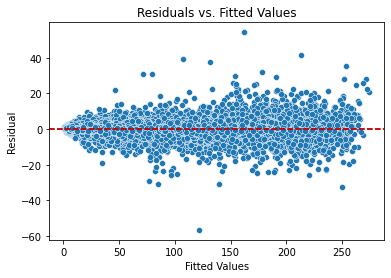

In [26]:
# Residuals vs Fitted Values
sns.scatterplot(data=validation, x='Prediction', y='Residual')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(np.mean(validation['Residual']), color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residual')
plt.title('Residuals vs. Fitted Values')
plt.show()

No trend or bias in the Residuals vs. Fitted Values plot and the mean of the residuals is approximately zero.

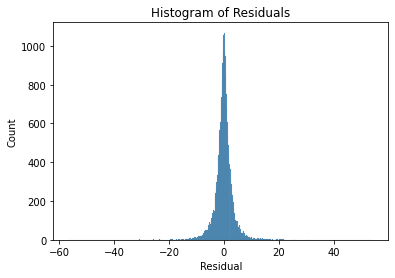

In [30]:
# Histogram of the Residuals
sns.histplot(data=validation, x='Residual')
plt.title('Histogram of Residuals')
plt.show()

The histogram of residuals displays a roughly normal distribution - there are some extreme residuals, but otherwise normally shaped.

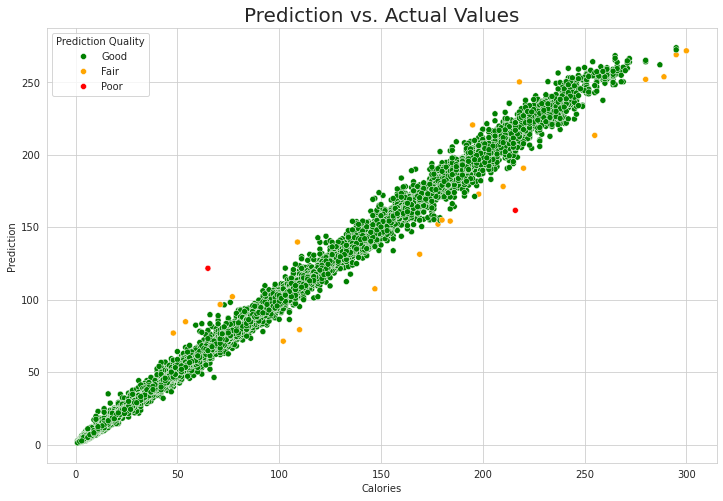

In [33]:
# Prediction vs. Actual
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=validation, x='Calories', y='Prediction', hue='Prediction Quality', hue_order=['Good', 'Fair', 'Poor'], palette=['green', 'orange', 'red'])
    plt.title('Prediction vs. Actual Values', fontsize=20)
    plt.show()

Most of the predictions appear quite good and there displays no pattern in the fair or poor predictions; the lower quality predictions occur for both low and high calorie values and the predictions underpredict and overpredict with no apparent pattern.

## Ensemble Model

### Ensemble Model Fitting
4 minutes

In [ ]:
# Ensemble Model
model = ensemble

# Fit the model to the training data
model.fit(X_train, y_train)

In [35]:
# Examine the feature importances
pd.Series(dict(model.named_estimators_)['Random Forest'].feature_importances_, index=X_train.columns).sort_values(ascending=False)

Duration*Relative_Intensity               0.271235
Duration*Heart_Rate                       0.221841
Duration*Body_Temp                        0.149191
Duration                                  0.107879
Weight*Duration*Relative_Intensity        0.069239
Heart_Rate                                0.054956
Duration*Weight                           0.033339
Relative_Intensity*Body_Temp              0.031831
Body_Temp                                 0.031343
Relative_Intensity                        0.012372
Age*Weight*Duration*Relative_Intensity    0.011304
Male                                      0.001985
Weight                                    0.001203
Age                                       0.001072
Height                                    0.000595
Senior                                    0.000355
BMI                                       0.000260
dtype: float64

In [36]:
# Examine the feature importances
pd.Series(dict(model.named_estimators_)['XGBoost'].feature_importances_, index=X_train.columns).sort_values(ascending=False)

Duration*Relative_Intensity               0.595532
Duration*Heart_Rate                       0.181786
Duration*Body_Temp                        0.128509
Duration                                  0.070757
Relative_Intensity*Body_Temp              0.007759
Weight*Duration*Relative_Intensity        0.004842
Male                                      0.003718
Relative_Intensity                        0.003479
Heart_Rate                                0.001484
Duration*Weight                           0.000686
Age*Weight*Duration*Relative_Intensity    0.000578
Weight                                    0.000451
Height                                    0.000177
Senior                                    0.000094
Age                                       0.000080
BMI                                       0.000036
Body_Temp                                 0.000031
dtype: float32

We can see from the Random Forest and XGBoost feature importances that the Duration interaction terms are the most predictive, particularly Duration*Relative_Intensity being the most important feature.

### Ensemble Predictions

In [37]:
# Make predictions on the test data
pred = model.predict(X_test)

# Ensure all predictions are non-negative
pred = non_negative(pred)

# Add the predictions to the test data
test['Calories'] = pred
test.head()

,Sex,Male,Age,Senior,Weight,Height,BMI,max_HR,Heart_Rate,Relative_Intensity,Body_Temp,Duration,Duration*Weight,Duration*Relative_Intensity,Duration*Heart_Rate,Duration*Body_Temp,Relative_Intensity*Body_Temp,Weight*Duration*Relative_Intensity,Age*Weight*Duration*Relative_Intensity,Calories
id,,,,,,,,,,,,,,,,,,,,
750000,male,1,45,0,81.0,177.0,25.854639,176.5,87.0,0.492918,39.8,7.0,567.0,3.450425,609.0,278.6,19.618130,279.484419,12576.798867,27.351127
750001,male,1,26,0,97.0,200.0,24.250000,189.8,101.0,0.532139,40.5,20.0,1940.0,10.642782,2020.0,810.0,21.551633,1032.349842,26841.095890,107.823047
750002,female,0,29,0,85.0,188.0,24.049344,187.7,102.0,0.543420,40.4,16.0,1360.0,8.694726,1632.0,646.4,21.954182,739.051678,21432.498668,86.979901
750003,female,0,39,0,73.0,172.0,24.675500,180.7,107.0,0.592142,40.6,20.0,1460.0,11.842833,2140.0,812.0,24.040952,864.526840,33716.546763,126.284125
750004,female,0,30,0,67.0,173.0,22.386314,187.0,94.0,0.502674,40.5,16.0,1072.0,8.042781,1504.0,648.0,20.358289,538.866310,16165.989305,75.978215


### Final Submission

In [ ]:
# Save the final prediction in the required format
results = test[['Calories']]
results.to_csv('Output/Predict_Calorie_Expenditure.csv')
results.head(15)

,Calories
id,
750000,27.351127
750001,107.823047
750002,86.979901
750003,126.284125
750004,75.978215
750005,21.669680
750006,48.186394
750007,6.621149
750008,10.180458


## Conclusion
From this project, I learned two key lessons: the predictive power of ensemble methods and the importance of managing memory and runtime effectively.
1. While XGBoost was the strongest individual model, the ensemble outperformed it consistently. Even a finely tuned XGBoost model (developed in a separate notebook) was unable to beat the ensemble. Ensembles can use multiple model to capture different aspects of the data.
2. I encountered significant challenges invovling memory usage and runtime, particularly with the random forest model. To resolve these issues, I learned how to parallelize both model fitting and hyperparameter tuning, and to tune models on a sampled subset of the data. These techniques saved considerable time and memory.

Ultimately, using the ensemble model earned me a spot in the top 40% in my first Kaggle competition.